# Лабораторна робота №2
Тема: Оглядовий аналіз та візуалізація даних (EDA)  
Студент: Луцюк Богдан КН-2  
Варіант: 4 / [https://www.kaggle.com/...](https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset)  
Дата: 22.10.2025  
Репозиторій: https://github.com/emissuu/UniTasks/tree/main/R/Lab2

## Init and general overview

In [146]:
install.packages("vcd")
install.packages("corrplot")
install.packages("car")
library(dplyr)
library(corrplot)
library(ggplot2)
library(vcd)
library(car)  

seed <- 16

data <- read.csv("data\\data.csv")
cat("General data overview:\n")
glimpse(data)
cat("\nNA cases count:", sum(is.na(data)))
cat("\nNA in income field:", sum(is.na(data$Income)))
cat("\nDuplicates count:", sum(duplicated(data[, -which(names(data) == "Id")])))


Installing package into ‘C:/Users/Meri/AppData/Local/R/win-library/4.5’
(as ‘lib’ is unspecified)
also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’



trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/cowplot_1.2.0.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/Deriv_4.2.0.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/microbenchmark_1.5.0.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/doBy_4.7.0.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/SparseM_1.84-2.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/MatrixModels_0.5-4.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/carData_3.0-5.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/abind_1.4-8.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/Formula_1.2-5.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/pbkrtest_0.5.5.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/quantreg_6.1.zip'
trying URL 'https://cran.rstudio.com/bin/windows/contrib/4.5/car_3.1-3.zip'


package ‘cowplot’ successfully unpacked and MD5 sums checked
package ‘Deriv’ successfully unpacked and MD5 sums checked
package ‘microbenchmark’ successfully unpacked and MD5 sums checked
package ‘doBy’ successfully unpacked and MD5 sums checked
package ‘SparseM’ successfully unpacked and MD5 sums checked
package ‘MatrixModels’ successfully unpacked and MD5 sums checked
package ‘carData’ successfully unpacked and MD5 sums checked
package ‘abind’ successfully unpacked and MD5 sums checked
package ‘Formula’ successfully unpacked and MD5 sums checked
package ‘pbkrtest’ successfully unpacked and MD5 sums checked
package ‘quantreg’ successfully unpacked and MD5 sums checked
package ‘car’ successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Meri\AppData\Local\Temp\RtmpILlOIo\downloaded_packages
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode



Warning messages:
1: package ‘car’ was built under R version 4.5.1 
2: package ‘carData’ was built under R version 4.5.1 


General data overview:
Rows: 2,240
Columns: 22
$ Id                  <int> 1826, 1, 10476, 1386, 5371, 7348, 4073, 1991, 4047…
$ Year_Birth          <int> 1970, 1961, 1958, 1967, 1989, 1958, 1954, 1967, 19…
$ Education           <chr> "Graduation", "Graduation", "Graduation", "Graduat…
$ Marital_Status      <chr> "Divorced", "Single", "Married", "Together", "Sing…
$ Income              <int> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 4…
$ Kidhome             <int> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,…
$ Teenhome            <int> 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,…
$ Dt_Customer         <chr> "6/16/2014", "6/15/2014", "5/13/2014", "11/5/2014"…
$ Recency             <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MntWines            <int> 189, 464, 134, 10, 6, 336, 769, 78, 384, 384, 450,…
$ MntFruits           <int> 104, 5, 11, 0, 16, 130, 80, 0, 0, 0, 26, 4, 82, 10…
$ MntMeatProducts     <int> 379, 64, 59, 1, 24, 411, 252, 11, 102, 102, 5

## Little cleaning

In [ ]:
# Cleaning duplicates
data_clean <- data |>
  distinct(across(-Id), .keep_all = TRUE)

# Parsing dates
data_clean <- data_clean |>
  mutate(
    Dt_Customer = as.Date(Dt_Customer, format = "%m/%d/%Y")
  )

# Meaning incomes
data_clean <- data_clean |>
  mutate(
    Income = if_else(!is.na(Income), Income, as.integer(mean(data_clean$Income, na.rm = TRUE)))
  )

# Adding some new characteristics
data_clean <- data_clean |>
  mutate(
    Age = as.integer(format(Sys.Date(), "%Y")) - Year_Birth,
    MntTotal = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds,
    NumTotalPurchases = NumWebPurchases + NumCatalogPurchases + NumStorePurchases,
    DaysCustomer = as.integer(as.Date(Sys.Date()) - Dt_Customer),
    HasChildren = as.logical(ifelse(Kidhome > 0 | Teenhome > 0, 1, 0)),
    TotalChildren = Kidhome + Teenhome
  ) 

# Cleaning outliers
data_clean <- data_clean |>
  mutate(
    Income = if_else(Income < 150000, Income, as.integer(mean(data_clean$Income))),
    Age = if_else(Age < 110, Age, as.integer(mean(data_clean$Age)))
  )

# Merging marital status
data_clean <- data_clean |>
  mutate(
    Marital_Status = if_else(Marital_Status %in% c("Single", "Married", "Widow", "Together", "Divorced"), Marital_Status, "Single")
  )


write.csv(data_clean, "data\\data_clean.csv", row.names = FALSE)
glimpse(data_clean)

Rows: 2,058
Columns: 28
$ Id                  <int> 1826, 1, 10476, 1386, 5371, 7348, 4073, 1991, 4047…
$ Year_Birth          <int> 1970, 1961, 1958, 1967, 1989, 1958, 1954, 1967, 19…
$ Education           <chr> "Graduation", "Graduation", "Graduation", "Graduat…
$ Marital_Status      <chr> "Divorced", "Single", "Married", "Together", "Sing…
$ Income              <int> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 4…
$ Kidhome             <int> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,…
$ Teenhome            <int> 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,…
$ Dt_Customer         <date> 2014-06-16, 2014-06-15, 2014-05-13, 2014-11-05, 2…
$ Recency             <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MntWines            <int> 189, 464, 134, 10, 6, 336, 769, 78, 384, 450, 140,…
$ MntFruits           <int> 104, 5, 11, 0, 16, 130, 80, 0, 0, 26, 4, 82, 10, 4…
$ MntMeatProducts     <int> 379, 64, 59, 1, 24, 411, 252, 11, 102, 535, 61, 44…
$ MntFishProduct

## Basic analysis
### Age

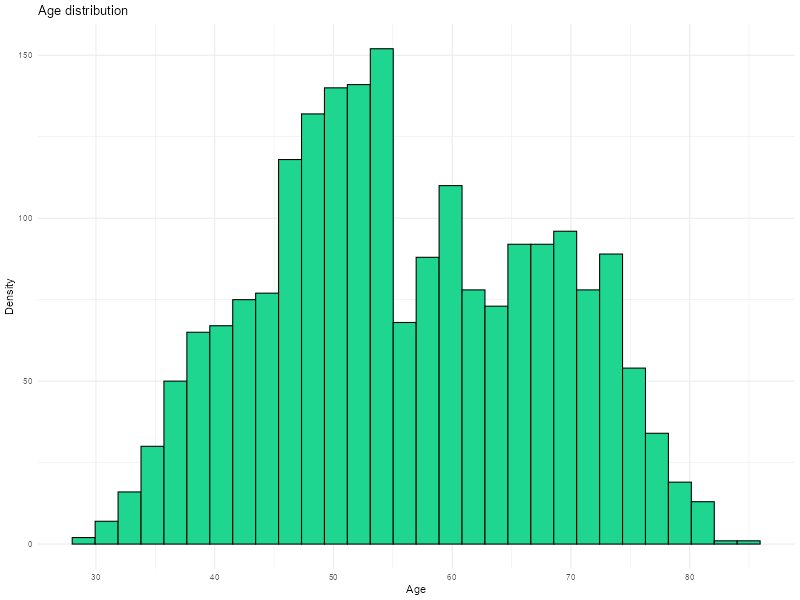

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [67]:
ggplot(data_clean, aes(x = Age)) +
  geom_histogram(fill = "#1ED68F", color = "black") +
  labs(title = "Age distribution", x = "Age", y = "Density") +
  theme_minimal()

### Education

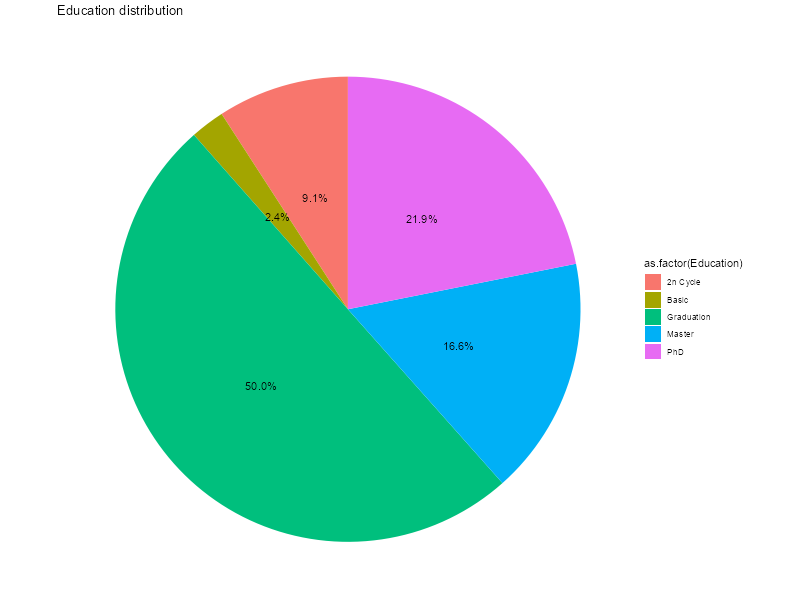

In [ ]:
ggplot(data_clean, aes(x = "", fill = as.factor(Education))) +
  geom_bar(width = 1) +
  coord_polar(theta = "y") +
  labs(title = "Education distribution") +
  geom_text(aes(label = scales::percent(..count../sum(..count..))), stat = "count", position = position_stack(vjust = 0.5)) +
  theme_void()

### Marital status distribution

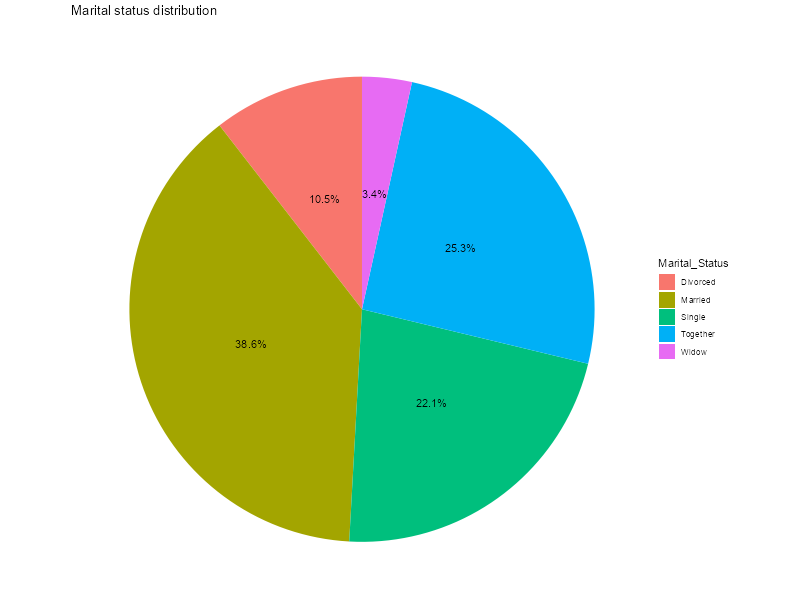

In [ ]:
ggplot(data_clean, aes(x = "", fill = Marital_Status)) +
  geom_bar(width = 1) +
  coord_polar(theta = "y") +
  labs(title = "Marital status") +
  geom_text(aes(label = scales::percent(..count../sum(..count..))), stat = "count", position = position_stack(vjust = 0.5)) +
  theme_void()

### Monthly new customers

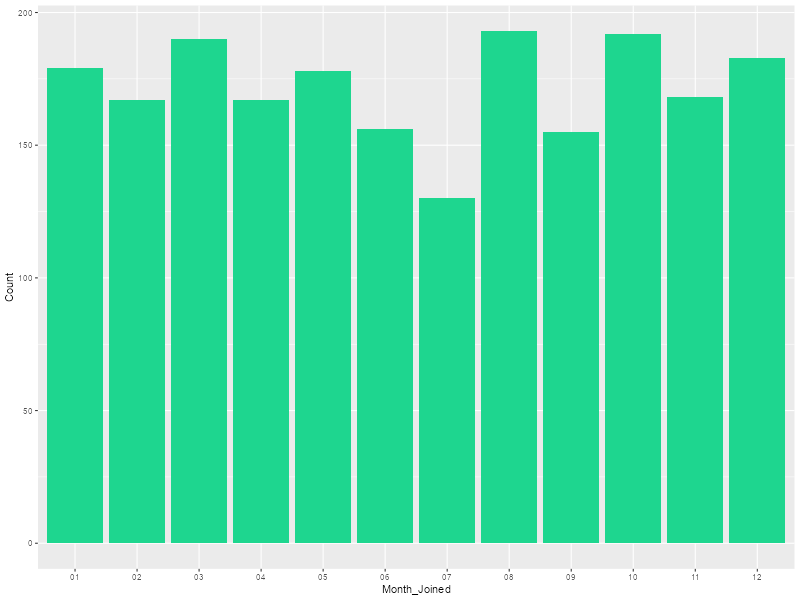

In [130]:
data_clean |>
  mutate(
    Month_Joined = as.factor(format(Dt_Customer, "%m"))
  ) |>
  group_by(Month_Joined) |>
  summarise(
    Count = n()
  ) |>
  ggplot(aes(x = Month_Joined, y = Count)) +
  geom_bar(fill = "#1ED68F", stat = "Identity")

## Correlation
### Pearson method

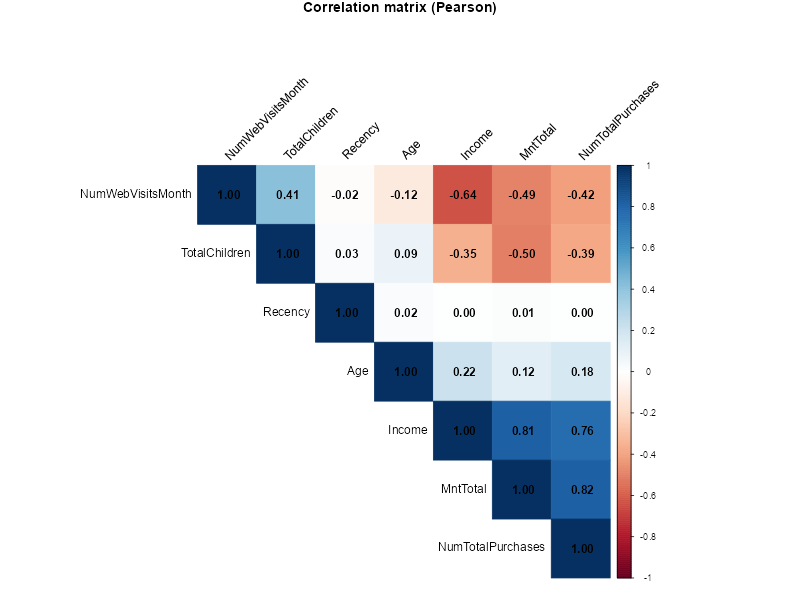

In [138]:
numeric_columns <- data_clean |>
  select_if(is.numeric)

cor_matrix <- cor(numeric_vars, method = "pearson")
corrplot(cor_matrix, method = "color", type = "upper", order = "hclust",
         addCoef.col = "black", tl.col = "black", tl.srt = 45,
         title = "Correlation matrix (Pearson)", mar=c(0,0,1,0))

### Spearman method

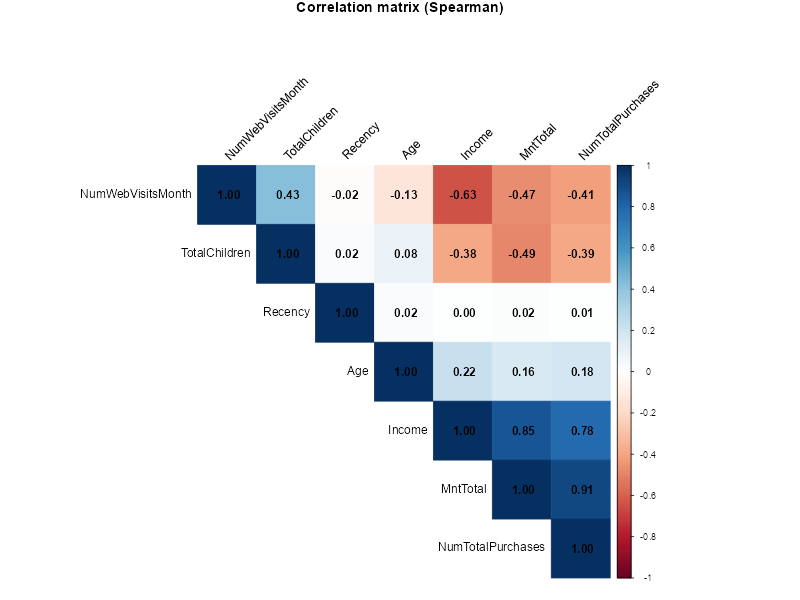

In [139]:
numeric_columns <- data_clean |>
  select_if(is.numeric)

cor_matrix <- cor(numeric_vars, method = "spearman")
corrplot(cor_matrix, method = "color", type = "upper", order = "hclust",
         addCoef.col = "black", tl.col = "black", tl.srt = 45,
         title = "Correlation matrix (Spearman)", mar=c(0,0,1,0))

### Cramer's V

In [ ]:
tbl <- table(data_clean$Education, data_clean$Marital_Status)
print(assocstats(tbl))

# do please

                    X^2 df P(> X^2)
Likelihood Ratio 17.107 16  0.37873
Pearson          16.448 16  0.42213

Phi-Coefficient   : NA 
Contingency Coeff.: 0.089 
Cramer's V        : 0.045 
